# 1. Import relevant packages.




In [69]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0hmqbyjv
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0hmqbyjv
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [70]:
!pip install datasets

In [71]:
import torch, numpy as np, pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import clip
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datasets import load_dataset
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from PIL import ImageFilter, ImageEnhance, Image
from torch.utils.data._utils.collate import default_collate
from torchvision.transforms import functional as TF
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import pairwise_distances


# 2. Setup Device Agnostic Code

In [72]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)

Running on: cuda


# 3. Load the pretrained Models.


### 3.1. Load the `CLIP` model

In [73]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [74]:
model_clip, preprocess = clip.load(name='ViT-B/32', device= "cuda" if torch.cuda.is_available() else "cpu")
model_clip.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

### 3.2. Load the pretrained `resnet50` model that has been trained on the `CIFAR10` dataset

In [75]:
baseline = resnet50(num_classes=10)
baseline_transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])
baseline.load_state_dict(torch.load("/content/resnet50_cifar10_new.pth", map_location=DEVICE))
baseline = baseline.to(DEVICE).eval()


# 4. Load and prepare the `CIFAR10` dataset for inference for both the `CLIP` and `resnet50` models

In [76]:
clip_transform = preprocess
cifar10_clip = datasets.CIFAR10(root="/content", train=False, download=True, transform=clip_transform)
cifar10_baseline = datasets.CIFAR10(root="/content", train=False, download=True, transform=baseline_transform)
clip_loader = DataLoader(cifar10_clip, batch_size=64, shuffle=False)
baseline_loader = DataLoader(cifar10_baseline, batch_size=64, shuffle=False)
name_list = cifar10_clip.classes
print(name_list)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 5. Define Zero-Shot Evaluation Function

In [77]:
def zero_shot_eval(prompt_list):
    text_tokens = clip.tokenize(prompt_list).to(DEVICE)
    with torch.inference_mode():
        text_features = model_clip.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct, total = 0, 0
    for images, labels in tqdm(clip_loader, desc="Zero-shot"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        with torch.inference_mode():
            image_features = model_clip.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * image_features @ text_features.T
            preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


### 5.1. Run with Different Prompt Styles

In [78]:
prompt_sets = {
    "plain": [cls for cls in name_list],
    "photo": [f"a photo of a {cls}" for cls in name_list],
    "detailed": [f"a detailed photo of a {cls}, natural scene" for cls in name_list]
}

results = {}
for name, prompts in prompt_sets.items():
    acc = zero_shot_eval(prompts)
    results[name] = round(acc * 100, 2)
    print(f"\n{name}: {acc*100:.2f}%\n")


Zero-shot: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s]



plain: 87.41%



Zero-shot: 100%|██████████| 157/157 [00:26<00:00,  5.93it/s]



photo: 88.77%



Zero-shot: 100%|██████████| 157/157 [00:26<00:00,  5.89it/s]


detailed: 88.31%



# 6. Compare with Supervised Baseline

In [79]:
def baseline_accuracy():
    correct, total = 0, 0
    for imgs, lbls in tqdm(baseline_loader, desc="Baseline"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        with torch.inference_mode():
            preds = baseline(imgs)
            preds = preds.argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return correct / total

base_acc = round(baseline_accuracy() * 100, 2)
print(f"\nBaseline ResNet-50 accuracy: {base_acc}%\n")

Baseline: 100%|██████████| 157/157 [00:10<00:00, 15.28it/s]


Baseline ResNet-50 accuracy: 93.32%



In [80]:
df_results = pd.DataFrame({
    "Prompt": list(results.keys()),
    "CLIP Accuracy (%)": list(results.values()),
    "Baseline Accuracy (%)": [base_acc]*len(results)
})

In [81]:
df_results


,Prompt,CLIP Accuracy (%),Baseline Accuracy (%)
0,plain,87.41,93.32
1,photo,88.77,93.32
2,detailed,88.31,93.32


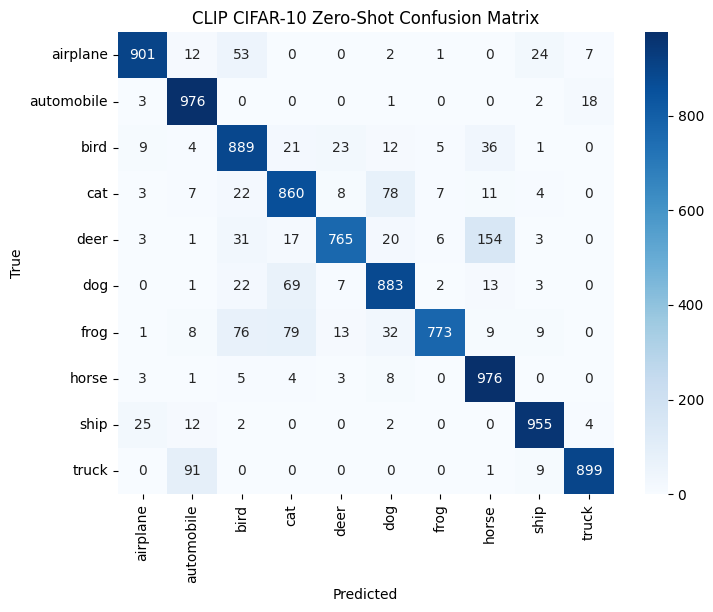


Per-class precision/recall:

              precision    recall  f1-score   support

    airplane       0.95      0.90      0.93      1000
  automobile       0.88      0.98      0.92      1000
        bird       0.81      0.89      0.85      1000
         cat       0.82      0.86      0.84      1000
        deer       0.93      0.77      0.84      1000
         dog       0.85      0.88      0.87      1000
        frog       0.97      0.77      0.86      1000
       horse       0.81      0.98      0.89      1000
        ship       0.95      0.95      0.95      1000
       truck       0.97      0.90      0.93      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [82]:
all_preds, all_labels = [], []
best_prompts = [f"a photo of a {cls}" for cls in name_list]
text_tokens = clip.tokenize(best_prompts).to(DEVICE)
with torch.inference_mode():
    text_features = model_clip.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    for images, labels in clip_loader:
        images = images.to(DEVICE)
        img_features = model_clip.encode_image(images)
        img_features /= img_features.norm(dim=-1, keepdim=True)
        preds = (100.0 * img_features @ text_features.T).argmax(dim=-1).cpu().tolist()
        all_preds += preds
        all_labels += labels.tolist()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=name_list, yticklabels=name_list, cmap="Blues")
plt.title("CLIP CIFAR-10 Zero-Shot Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()

print("\nPer-class precision/recall:\n")
print(classification_report(all_labels, all_preds, target_names=name_list))

In [83]:
per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
best_idx = per_class_acc.argmax()
worst_idx = per_class_acc.argmin()
print(f"\nBest CIFAR-10 class: {name_list[best_idx]} ({per_class_acc[best_idx]:.2f}% accuracy)")
print(f"Worst CIFAR-10 class: {name_list[worst_idx]} ({per_class_acc[worst_idx]:.2f}% accuracy)")


Best CIFAR-10 class: automobile (97.60% accuracy)
Worst CIFAR-10 class: deer (76.50% accuracy)


# 7. Load the `PACS` dataset to evaluate `CLIP`

In [84]:
pacs = load_dataset("flwrlabs/pacs", split="train")

print(pacs)
print(pacs.features)

Dataset({
    features: ['image', 'domain', 'label'],
    num_rows: 9991
})
{'image': Image(mode=None, decode=True), 'domain': Value('string'), 'label': ClassLabel(names=['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person'])}


In [85]:
print(pacs[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=227x227 at 0x7CCF763CE750>, 'domain': 'art_painting', 'label': 0}


### 7.1. Filter the `PACS` dataset to use only the `sketch` domain

In [86]:
pacs_sketch = pacs.filter(lambda ex: ex["domain"] == "sketch")
print(len(pacs_sketch))

3929


### 7.2. View a few skteches from `PACS`

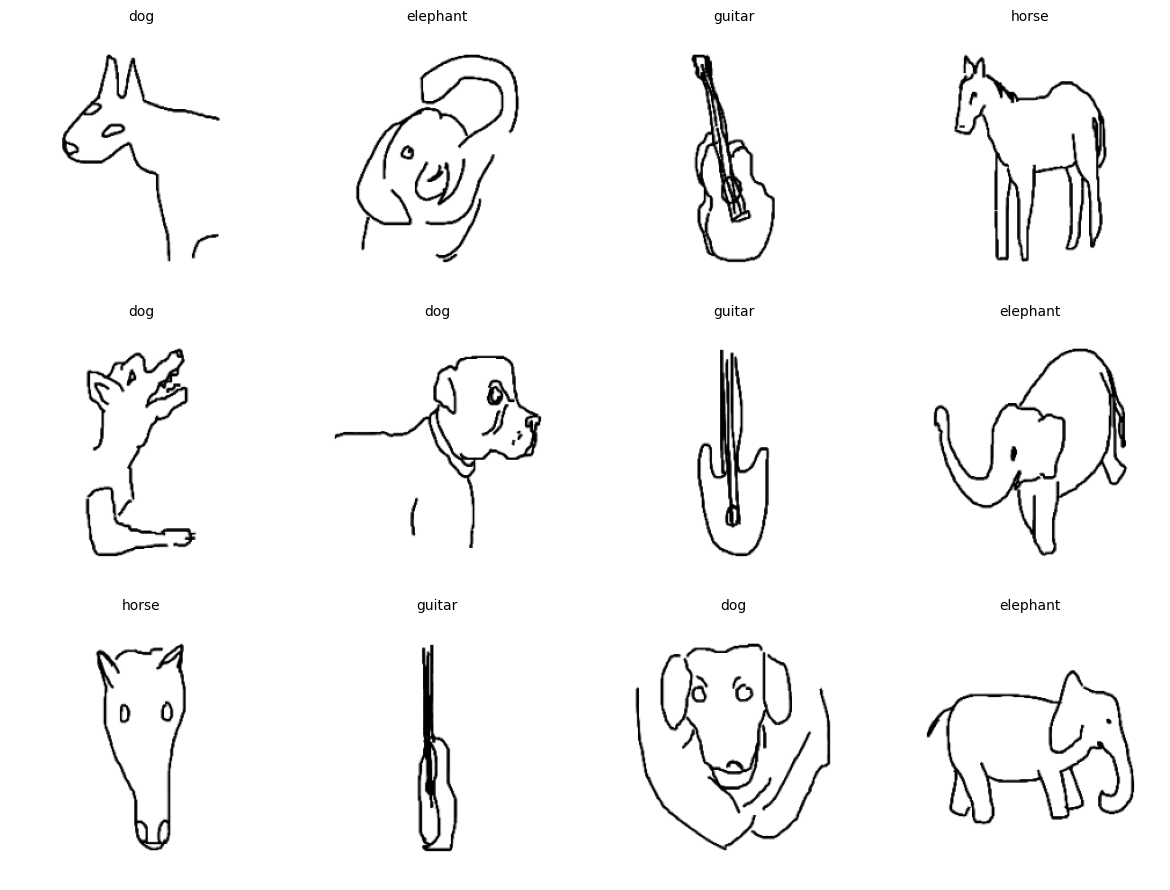

In [87]:
def show_random_images(hf_dataset, n=12):
    # choose n random Python int indices
    idxs = random.sample(range(len(hf_dataset)), n)
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=(3*ncols, 3*nrows))

    for i, idx in enumerate(idxs):
        ex = hf_dataset[int(idx)]
        img = ex["image"]
        if "label_name" in ex:
            label = ex["label_name"]
        else:
            label = hf_dataset.features["label"].names[ex["label"]]
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img)
        plt.title(label, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(pacs_sketch, n=12)


### 7.3. Make a custom `dataset` and `dataloader` out of sketch subset of the data

In [88]:
class HFPACSSketch(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.ds = hf_dataset
        self.transform = transform
        # Map numeric labels to names from the features metadata
        self.classes = self.ds.features["label"].names

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[int(idx)]  # ensure Python int
        img = ex["image"].convert("RGB")
        lbl = ex["label"]       # integer id
        return self.transform(img), lbl

# Create dataset & loader
pacs_sketch_dataset = HFPACSSketch(pacs_sketch, preprocess)
pacs_sketch_loader  = DataLoader(pacs_sketch_dataset, batch_size=64, shuffle=False)

print("Classes:", pacs_sketch_dataset.classes)

Classes: ['dog', 'elephant', 'giraffe', 'guitar', 'horse', 'house', 'person']


# 8. Run Zero-Shot Classification on `PACS-Sketch`

In [89]:
def zero_shot_eval_custom(loader, prompt_list):
    text_tokens = clip.tokenize(prompt_list).to(DEVICE)
    with torch.inference_mode():
        text_features = model_clip.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    correct, total = 0, 0
    for imgs, lbls in tqdm(loader, desc="PACS-Sketch Zero-shot"):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        with torch.inference_mode():
            img_features = model_clip.encode_image(imgs)
            img_features /= img_features.norm(dim=-1, keepdim=True)
            logits = 100.0 * img_features @ text_features.T
            preds = logits.argmax(dim=-1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return correct / total

In [90]:
pacs_prompts = [f"a sketch of a {cls}" for cls in pacs_sketch_dataset.classes]
acc_pacs = zero_shot_eval_custom(pacs_sketch_loader, pacs_prompts)
print(f"\nCLIP zero-shot accuracy on PACS Sketch: {acc_pacs*100:.2f}%\n")


PACS-Sketch Zero-shot: 100%|██████████| 62/62 [00:17<00:00,  3.64it/s]


CLIP zero-shot accuracy on PACS Sketch: 85.16%



# 9. Compare Zero-Shot performance between a photo from `CIFAR10` and `PACS-SKETCH`

In [91]:
summary_df = pd.DataFrame([
    {"Dataset": "CIFAR-10", "Prompt": "a photo of a {class}", "CLIP Zero-shot (%)": results["photo"]},
    {"Dataset": "PACS-Sketch", "Prompt": "a sketch of a {class}", "CLIP Zero-shot (%)": round(acc_pacs * 100, 2)}
])

summary_df

,Dataset,Prompt,CLIP Zero-shot (%)
0,CIFAR-10,a photo of a {class},88.77
1,PACS-Sketch,a sketch of a {class},85.16


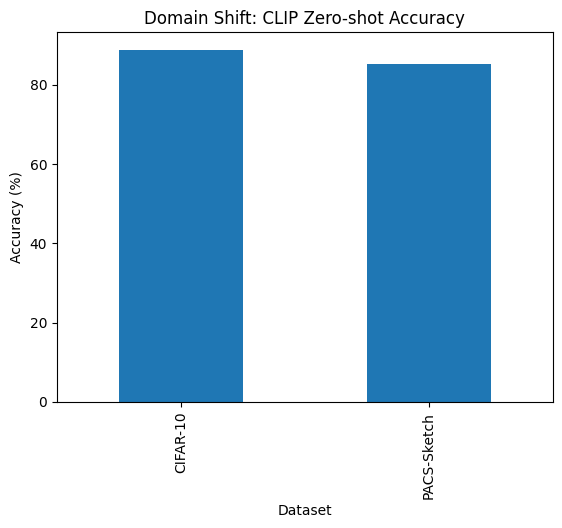

In [92]:
summary_df.plot(x="Dataset", y="CLIP Zero-shot (%)", kind="bar", legend=False,
                title="Domain Shift: CLIP Zero-shot Accuracy")
plt.ylabel("Accuracy (%)"); plt.show()

# 10. Experiments with **Prompt Engineering**

In [93]:
prompt_sets_extra = {
    "double_name": [f"a photo of a {cls}, {cls}" for cls in name_list],
    "object_on_plain": [f"a {cls} on a plain background" for cls in name_list],
    "natural_scene": [f"a natural scene of a {cls}" for cls in name_list],
}

In [94]:
results_extra = {}
for style, prompts in prompt_sets_extra.items():
    acc = zero_shot_eval(prompts)
    results_extra[style] = round(acc * 100, 2)
    print(f"\n{style}: {results_extra[style]}%\n")

Zero-shot: 100%|██████████| 157/157 [00:27<00:00,  5.62it/s]



double_name: 87.65%



Zero-shot: 100%|██████████| 157/157 [00:27<00:00,  5.61it/s]



object_on_plain: 88.6%



Zero-shot: 100%|██████████| 157/157 [00:27<00:00,  5.76it/s]


natural_scene: 86.52%



In [95]:
prompt_summary_df = pd.DataFrame([
    {"Prompt Style": k, "CIFAR-10 Zero-shot (%)": v}
    for k, v in {**results, **results_extra}.items()
])
prompt_summary_df


,Prompt Style,CIFAR-10 Zero-shot (%)
0,plain,87.41
1,photo,88.77
2,detailed,88.31
3,double_name,87.65
4,object_on_plain,88.60
5,natural_scene,86.52


In [96]:
print("Best prompt style:\n",
      prompt_summary_df.loc[prompt_summary_df['CIFAR-10 Zero-shot (%)'].idxmax()])
print("\nWorst prompt style:\n",
      prompt_summary_df.loc[prompt_summary_df['CIFAR-10 Zero-shot (%)'].idxmin()])

Best prompt style:
 Prompt Style              photo
CIFAR-10 Zero-shot (%)    88.77
Name: 1, dtype: object

Worst prompt style:
 Prompt Style              natural_scene
CIFAR-10 Zero-shot (%)            86.52
Name: 5, dtype: object


# 11. Image–Text Retrieval with `CLIP`

### 11.1.  Sample a small image subset (mix of CIFAR-10 photos)

In [97]:
num_samples = 20
sample_indices = random.sample(range(len(cifar10_clip)), num_samples)
retrieval_subset = [cifar10_clip[i] for i in sample_indices]
retrieval_images = torch.stack([img for img, _ in retrieval_subset]).to(DEVICE)
retrieval_labels = [lbl for _, lbl in retrieval_subset]

### 11.2. Encode the subset images with CLIP

In [98]:
with torch.inference_mode():
    image_features = model_clip.encode_image(retrieval_images)
    image_features /= image_features.norm(dim=-1, keepdim=True)


### 11.3. Prepare a small set of text queries

In [99]:
text_queries = [f"a photo of a {cls}" for cls in name_list] + [f"a close-up photo of a {cls}" for cls in random.sample(name_list, 3)]

with torch.inference_mode():
    text_tokens = clip.tokenize(text_queries).to(DEVICE)
    text_features = model_clip.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)


### 11.4. For each text query, find the most similar image in the subset

In [100]:
retrieval_results = []
with torch.inference_mode():
    sims = text_features @ image_features.T
    best_img_idx = sims.argmax(dim=1).cpu().numpy()
    best_scores  = sims.max(dim=1).values.cpu().numpy()

for q_idx, query in enumerate(text_queries):
    idx = int(best_img_idx[q_idx])
    predicted_class = name_list[retrieval_labels[idx]]
    retrieval_results.append({
        "Text Query": query,
        "Retrieved Image Class": predicted_class,
        "Similarity Score": round(float(best_scores[q_idx]), 3)
    })

retrieval_df = pd.DataFrame(retrieval_results)
print("\n=== Text → Image Retrieval Results ===\n")
display(retrieval_df.head(10))


=== Text → Image Retrieval Results ===



,Text Query,Retrieved Image Class,Similarity Score
0,a photo of a airplane,airplane,0.287
1,a photo of a automobile,automobile,0.233
2,a photo of a bird,bird,0.269
3,a photo of a cat,deer,0.240
4,a photo of a deer,deer,0.294
5,a photo of a dog,deer,0.251
6,a photo of a frog,frog,0.265
7,a photo of a horse,horse,0.280
8,a photo of a ship,ship,0.265
9,a photo of a truck,truck,0.244


### 11.5. Reverse Retrieval: For each image, find the best matching text quer

In [101]:
reverse_results = []
with torch.inference_mode():
    sims_rev = image_features @ text_features.T  # [num_images, num_queries]
    best_text_idx = sims_rev.argmax(dim=1).cpu().numpy()
    best_text_scores = sims_rev.max(dim=1).values.cpu().numpy()

for img_idx, lbl in enumerate(retrieval_labels):
    reverse_results.append({
        "True Image Class": name_list[lbl],
        "Best Matching Query": text_queries[int(best_text_idx[img_idx])],
        "Similarity Score": round(float(best_text_scores[img_idx]), 3)
    })

reverse_df = pd.DataFrame(reverse_results)
print("\n=== Image → Text Retrieval Results ===\n")
display(reverse_df.head(10))


=== Image → Text Retrieval Results ===



,True Image Class,Best Matching Query,Similarity Score
0,deer,a photo of a deer,0.293
1,deer,a photo of a deer,0.270
2,bird,a photo of a bird,0.269
3,automobile,a photo of a automobile,0.233
4,airplane,a photo of a airplane,0.273
5,deer,a photo of a horse,0.257
6,deer,a close-up photo of a deer,0.291
7,horse,a photo of a horse,0.260
8,airplane,a photo of a airplane,0.266
9,frog,a photo of a frog,0.265


In [102]:
topk = 5
correct = 0
with torch.inference_mode():
    for images, labels in clip_loader:
        images = images.to(DEVICE); labels = labels.to(DEVICE)
        img_feats = model_clip.encode_image(images)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)
        sims = 100.0 * img_feats @ text_features.T
        topk_preds = sims.topk(topk, dim=-1).indices
        correct += sum(lbl.item() in topk_preds[i].cpu().tolist()
                       for i, lbl in enumerate(labels))
print(f"Top-{topk} retrieval accuracy: {correct / len(cifar10_clip) * 100:.2f}%")

Top-5 retrieval accuracy: 98.98%


In [103]:
for k in [1,3,5]:
    correct = 0
    with torch.inference_mode():
        for images, labels in clip_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            img_feats = model_clip.encode_image(images)
            img_feats /= img_feats.norm(dim=-1, keepdim=True)
            sims = 100.0 * img_feats @ text_features.T
            topk_preds = sims.topk(k, dim=-1).indices
            correct += sum(lbl.item() in topk_preds[i].cpu().tolist()
                           for i, lbl in enumerate(labels))
    print(f"Precision@{k}: {correct / len(cifar10_clip) * 100:.2f}%")

Precision@1: 79.12%
Precision@3: 97.00%
Precision@5: 98.98%


# 12. Representation Analysis – `CLIP` vs `ResNet50`

### 12.1. Build a mixed dataset: `CIFAR10` (**photos**), `CIFAR10` **grayscale**, `PACS-sketch`

In [104]:
def to_grayscale(img):
    return transforms.Grayscale(num_output_channels=3)(img)

grayscale_transform = transforms.Compose([to_grayscale, clip_transform])

cifar_subset = torch.utils.data.Subset(cifar10_clip, random.sample(range(len(cifar10_clip)), 200))
cifar_gray_dataset = datasets.CIFAR10(root="/content", train=False, download=True, transform=grayscale_transform)
cifar_gray_subset = torch.utils.data.Subset(cifar_gray_dataset, random.sample(range(len(cifar_gray_dataset)), 200))
pacs_sketch_subset = pacs_sketch.shuffle(seed=42).select(range(200))

# Wrap PACS sketch subset with our class
pacs_sketch_subset_ds = HFPACSSketch(pacs_sketch_subset, preprocess)

# Combine into one list [(img, label, domain)]
def collect_samples(ds, domain_name, n=200):
    out = []
    for i in range(len(ds)):
        img, lbl = ds[i]
        out.append((img, lbl, domain_name))
    return out

samples = collect_samples(cifar_subset, "photo") \
        + collect_samples(cifar_gray_subset, "grayscale") \
        + collect_samples(pacs_sketch_subset_ds, "sketch")


### 12.2. Create tensors and labels

In [105]:
imgs = torch.stack([s[0] for s in samples]).to(DEVICE)
labels = [s[1] for s in samples]
domains = [s[2] for s in samples]

### 12.3. Encode with `CLIP` and `ResNet`

In [106]:
with torch.inference_mode():
    clip_feats = model_clip.encode_image(imgs)
    clip_feats = clip_feats / clip_feats.norm(dim=-1, keepdim=True)
    baseline_feats = baseline(imgs)
    baseline_feats = F.normalize(baseline_feats, dim=-1)


### 12.4. Dimensionality reduction

In [107]:
def reduce_features(features, method="tsne", n_components=2):
    feats = features.cpu().numpy()
    if method == "pca":
        reducer = PCA(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(feats)
    else:
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
        reduced = reducer.fit_transform(feats)
    return reduced

In [108]:
clip_2d = reduce_features(clip_feats, method="tsne")
baseline_2d = reduce_features(baseline_feats, method="tsne")

### 12.5. Plot `CLIP` embeddings

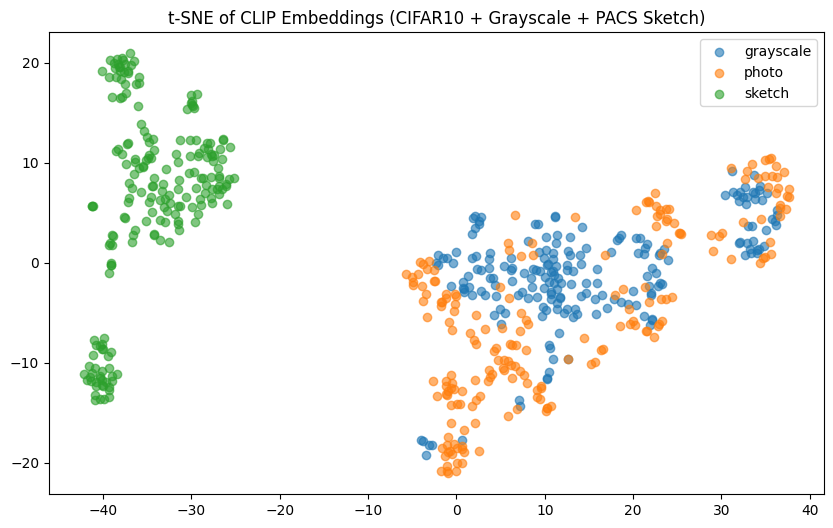

In [109]:
plt.figure(figsize=(10,6))
for domain in set(domains):
    idxs = [i for i, d in enumerate(domains) if d == domain]
    plt.scatter(clip_2d[idxs,0], clip_2d[idxs,1], label=domain, alpha=0.6)
plt.title("t-SNE of CLIP Embeddings (CIFAR10 + Grayscale + PACS Sketch)")
plt.legend()
plt.show()

### 12.6. Plot `ResNet50` embeddings

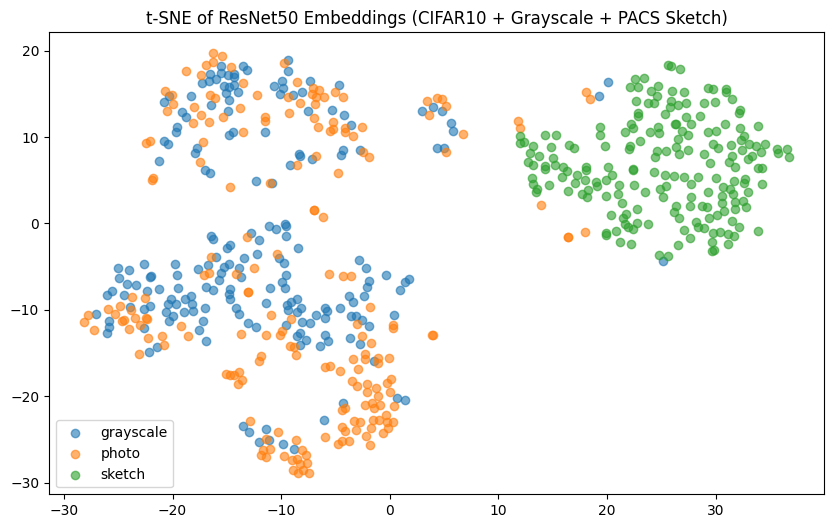

In [110]:
plt.figure(figsize=(10,6))
for domain in set(domains):
    idxs = [i for i, d in enumerate(domains) if d == domain]
    plt.scatter(baseline_2d[idxs,0], baseline_2d[idxs,1], label=domain, alpha=0.6)
plt.title("t-SNE of ResNet50 Embeddings (CIFAR10 + Grayscale + PACS Sketch)")
plt.legend()
plt.show()

In [111]:
clip_dists = pairwise_distances(clip_2d)
baseline_dists = pairwise_distances(baseline_2d)

def mean_intra_domain(dists, domains):
    vals = []
    for d in set(domains):
        idx = [i for i, dom in enumerate(domains) if dom==d]
        sub = dists[np.ix_(idx, idx)]
        vals.append(sub[np.triu_indices_from(sub, k=1)].mean())
    return np.mean(vals)

print("Mean intra-domain distance (CLIP):",
      mean_intra_domain(clip_dists, domains))
print("Mean intra-domain distance (ResNet):",
      mean_intra_domain(baseline_dists, domains))

Mean intra-domain distance (CLIP): 15.464187
Mean intra-domain distance (ResNet): 16.79578


In [112]:
def mean_inter_domain(dists, domains):
    vals = []
    for d in set(domains):
        idx_d = [i for i, dom in enumerate(domains) if dom==d]
        idx_not = [i for i, dom in enumerate(domains) if dom!=d]
        sub = dists[np.ix_(idx_d, idx_not)]
        vals.append(sub.mean())
    return np.mean(vals)

clip_inter = mean_inter_domain(clip_dists, domains)
baseline_inter = mean_inter_domain(baseline_dists, domains)

print(f"\nCLIP inter/intra distance ratio: {clip_inter/mean_intra_domain(clip_dists, domains):.2f}")
print(f"ResNet inter/intra distance ratio: {baseline_inter/mean_intra_domain(baseline_dists, domains):.2f}")


CLIP inter/intra distance ratio: 2.57
ResNet inter/intra distance ratio: 2.00


# 13. Shape vs Texture Bias in `CLIP` vs `ResNet50`

In [113]:
conflict = load_dataset("paulgavrikov/frequency-cue-conflict", split="test")
print(conflict)
print(conflict.features)
print(conflict[0])

Dataset({
    features: ['image', 'lf_label', 'hf_label'],
    num_rows: 1280
})
{'image': Image(mode=None, decode=True), 'lf_label': Value('string'), 'hf_label': Value('string')}
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=224x224 at 0x7CCF8D4E7200>, 'lf_label': 'airplane', 'hf_label': 'airplane'}


In [114]:
class ConflictDataset(torch.utils.data.Dataset):
    """
    Returns both CLIP- and ResNet-ready tensors plus the original PIL image.
    """
    def __init__(self, hf_dataset, clip_transform, resnet_transform):
        self.ds = hf_dataset
        self.clip_transform = clip_transform
        self.resnet_transform = resnet_transform
        lf_unique = sorted(set(self.ds["lf_label"]))
        hf_unique = sorted(set(self.ds["hf_label"]))
        self.classes = sorted(set(lf_unique + hf_unique))

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[int(idx)]
        img = ex["image"].convert("RGB")
        lf_idx = self.classes.index(ex["lf_label"])
        hf_idx = self.classes.index(ex["hf_label"])
        return {
            "clip_img": self.clip_transform(img),
            "resnet_img": self.resnet_transform(img),
            "lf_label": lf_idx,
            "hf_label": hf_idx,
            "pil_img": img   # keep original PIL for later plotting
        }

def custom_collate(batch):
    """
    Keep a list of PIL images while collating tensors normally.
    """
    elem = batch[0]
    out = {}
    for key in elem:
        if key == "pil_img":
            out[key] = [d[key] for d in batch]
        else:
            out[key] = default_collate([d[key] for d in batch])
    return out

In [115]:
conflict_dataset = ConflictDataset(conflict, preprocess, baseline_transform)
conflict_loader  = DataLoader(
    conflict_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=custom_collate
)
print("Conflict dataset classes:", conflict_dataset.classes)

Conflict dataset classes: ['airplane', 'bear', 'bicycle', 'bird', 'boat', 'bottle', 'car', 'cat', 'chair', 'clock', 'dog', 'elephant', 'keyboard', 'knife', 'oven', 'truck']


In [116]:
text_tokens = clip.tokenize(conflict_dataset.classes).to(DEVICE)
with torch.inference_mode():
    text_features = model_clip.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [117]:
# --- Run inference -----------------------------------------------------------
clip_preds, resnet_preds = [], []
lf_labels, hf_labels     = [], []
sample_images            = []   # keep PIL images only for plotting

with torch.inference_mode():
    for batch in tqdm(conflict_loader, desc="Shape-Texture"):
        clip_imgs  = batch["clip_img"].to(DEVICE)
        resnet_imgs = batch["resnet_img"].to(DEVICE)

        # Convert numeric labels back to class names
        lf_labels.extend([conflict_dataset.classes[i] for i in batch["lf_label"]])
        hf_labels.extend([conflict_dataset.classes[i] for i in batch["hf_label"]])
        sample_images.extend(batch["pil_img"])

        # CLIP predictions
        image_features = model_clip.encode_image(clip_imgs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100.0 * image_features @ text_features.T
        clip_idx = logits.argmax(dim=-1).cpu().tolist()
        clip_preds.extend([conflict_dataset.classes[i] for i in clip_idx])

        # ResNet predictions
        r_logits = baseline(resnet_imgs)
        r_idx = r_logits.argmax(dim=-1).cpu().tolist()
        resnet_preds.extend([conflict_dataset.classes[i] for i in r_idx])

Shape-Texture: 100%|██████████| 40/40 [00:05<00:00,  7.63it/s]


In [118]:
conflict_df = pd.DataFrame({
    "Low-freq (Shape) Label": lf_labels,
    "High-freq (Texture) Label": hf_labels,
    "CLIP Prediction": clip_preds,
    "ResNet Prediction": resnet_preds
})

print("\n=== Shape vs Texture Bias Results ===\n")
display(conflict_df.head(10))


=== Shape vs Texture Bias Results ===



,Low-freq (Shape) Label,High-freq (Texture) Label,CLIP Prediction,ResNet Prediction
0,airplane,airplane,airplane,airplane
1,airplane,airplane,airplane,airplane
2,airplane,airplane,airplane,airplane
3,airplane,airplane,oven,chair
4,airplane,airplane,airplane,airplane
5,airplane,bear,airplane,airplane
6,airplane,bear,airplane,airplane
7,airplane,bear,bird,airplane
8,airplane,bear,airplane,airplane
9,airplane,bear,airplane,airplane


In [119]:
clip_shape_acc   = np.mean(conflict_df["Low-freq (Shape) Label"]  == conflict_df["CLIP Prediction"])
clip_texture_acc = np.mean(conflict_df["High-freq (Texture) Label"] == conflict_df["CLIP Prediction"])
res_shape_acc    = np.mean(conflict_df["Low-freq (Shape) Label"]  == conflict_df["ResNet Prediction"])
res_texture_acc  = np.mean(conflict_df["High-freq (Texture) Label"] == conflict_df["ResNet Prediction"])

bias_summary = pd.DataFrame([
    {"Model": "CLIP",   "Shape agreement (%)": round(clip_shape_acc*100,2),
                        "Texture agreement (%)": round(clip_texture_acc*100,2)},
    {"Model": "ResNet", "Shape agreement (%)": round(res_shape_acc*100,2),
                        "Texture agreement (%)": round(res_texture_acc*100,2)}
])
print("\n=== Shape vs Texture Agreement Summary ===\n")
display(bias_summary)


=== Shape vs Texture Agreement Summary ===



,Model,Shape agreement (%),Texture agreement (%)
0,CLIP,57.27,13.28
1,ResNet,9.53,7.19


In [120]:
def show_conflict_samples(df, pil_images, n=6):
    plt.figure(figsize=(12, 6))
    n = min(n, len(df))
    chosen_idx = np.random.choice(len(df), n, replace=False)
    for i, idx in enumerate(chosen_idx):
        row = df.iloc[idx]
        plt.subplot(2, n//2, i+1)
        plt.imshow(pil_images[idx])
        title = (f"Shape: {row['Low-freq (Shape) Label']}\n"
                 f"Texture: {row['High-freq (Texture) Label']}\n"
                 f"CLIP: {row['CLIP Prediction']}, ResNet: {row['ResNet Prediction']}")
        plt.title(title, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

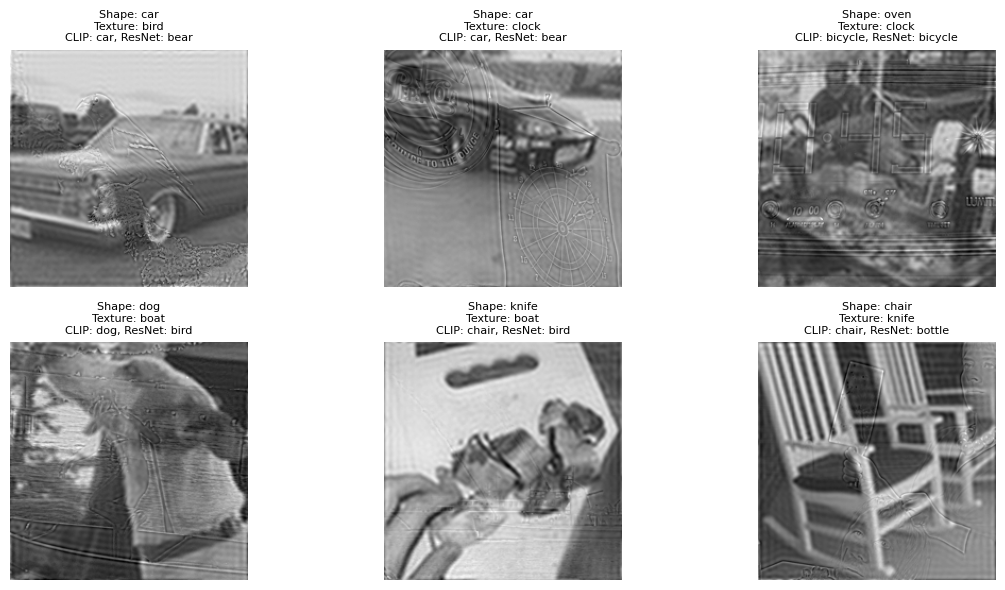

In [121]:
show_conflict_samples(conflict_df, sample_images, n=6)



Shape vs Texture Cross-tab (CLIP):
 col_0  False  True   All
row_0                   
False    440   107   547
True     670    63   733
All     1110   170  1280


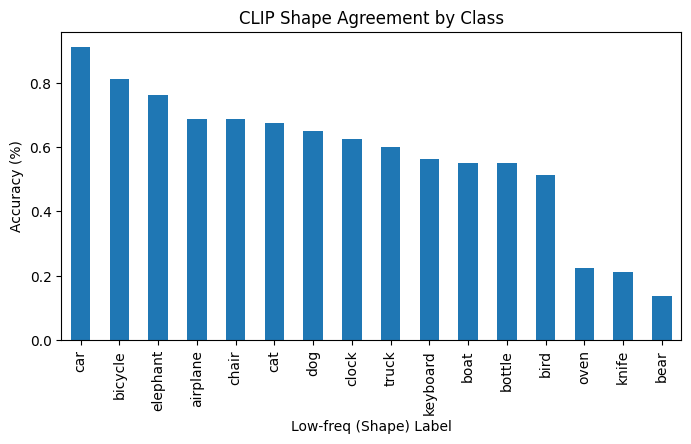

In [122]:
print("\nShape vs Texture Cross-tab (CLIP):\n",
      pd.crosstab(conflict_df["Low-freq (Shape) Label"]==conflict_df["CLIP Prediction"],
                  conflict_df["High-freq (Texture) Label"]==conflict_df["CLIP Prediction"],
                  margins=True))

# --- Per-class shape agreement bar chart ---
per_class = (conflict_df
    .assign(correct_shape=lambda df: df["Low-freq (Shape) Label"]==df["CLIP Prediction"])
    .groupby("Low-freq (Shape) Label")["correct_shape"].mean().sort_values(ascending=False))
per_class.plot(kind="bar", figsize=(8,4), title="CLIP Shape Agreement by Class")
plt.ylabel("Accuracy (%)"); plt.show()

In [123]:
per_class_summary = conflict_df.groupby("Low-freq (Shape) Label").apply(
    lambda df: pd.Series({
        "Shape Acc (%)": (df["Low-freq (Shape) Label"]==df["CLIP Prediction"]).mean()*100,
        "Texture Acc (%)": (df["High-freq (Texture) Label"]==df["CLIP Prediction"]).mean()*100
    })
)
print("\nPer-class CLIP shape vs texture accuracy (%):\n")
print(per_class_summary.round(2))


Per-class CLIP shape vs texture accuracy (%):

                        Shape Acc (%)  Texture Acc (%)
Low-freq (Shape) Label                                
airplane                        68.75            11.25
bear                            13.75            20.00
bicycle                         81.25            12.50
bird                            51.25            13.75
boat                            55.00            16.25
bottle                          55.00            10.00
car                             91.25             8.75
cat                             67.50            12.50
chair                           68.75            16.25
clock                           62.50            11.25
dog                             65.00            13.75
elephant                        76.25            11.25
keyboard                        56.25            10.00
knife                           21.25            15.00
oven                            22.50            16.25
truck            

/tmp/ipython-input-2555055030.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  per_class_summary = conflict_df.groupby("Low-freq (Shape) Label").apply(


# 14. Robustness Tests – `CLIP` vs `ResNet50`

In [124]:
def add_gaussian_noise(img, std=0.3):
    """
    Add Gaussian noise to a PIL image.
    std: noise standard deviation in [0,1] range.
    """
    arr = np.array(img).astype(np.float32) / 255.0
    noise = np.random.normal(0, std, arr.shape)
    noisy = np.clip(arr + noise, 0, 1)
    return Image.fromarray((noisy * 255).astype(np.uint8))

def apply_blur(img, radius=5):
    """
    Apply strong Gaussian blur to a PIL image.
    """
    return img.filter(ImageFilter.GaussianBlur(radius))

In [125]:
num_test_samples = 8
subset_indices = random.sample(range(len(cifar10_clip)), num_test_samples)

perturb_records = []

In [126]:
text_tokens = clip.tokenize(name_list).to(DEVICE)
with torch.inference_mode():
    text_features = model_clip.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [127]:
with torch.inference_mode():
    for idx in subset_indices:
        pil_img, label = cifar10_clip[idx]
        # Convert the CLIP-preprocessed tensor back to PIL for corruption
        orig_pil = TF.to_pil_image(pil_img)

        # Make corrupted versions
        noisy_img = add_gaussian_noise(orig_pil, std=0.4)
        blur_img  = apply_blur(orig_pil, radius=5)

        for corruption_name, corrupt_pil in [("Noisy", noisy_img), ("Blurred", blur_img)]:
            # CLIP
            clip_in = preprocess(corrupt_pil).unsqueeze(0).to(DEVICE)
            clip_feat = model_clip.encode_image(clip_in)
            clip_feat /= clip_feat.norm(dim=-1, keepdim=True)
            clip_idx = (100.0 * clip_feat @ text_features.T).argmax(dim=-1).item()
            clip_pred = name_list[clip_idx]

            # ResNet
            resnet_in = baseline_transform(corrupt_pil).unsqueeze(0).to(DEVICE)
            r_idx = baseline(resnet_in).argmax(dim=-1).item()
            res_pred = name_list[r_idx]

            perturb_records.append({
                "True Label": name_list[label],
                "Corruption": corruption_name,
                "CLIP Prediction": clip_pred,
                "ResNet Prediction": res_pred,
                "image_pil": corrupt_pil
            })


In [128]:
robust_df = pd.DataFrame(perturb_records)
print("\n=== Robustness Test Results (first few rows) ===\n")
display(robust_df.drop(columns=['image_pil']).head(10))



=== Robustness Test Results (first few rows) ===



,True Label,Corruption,CLIP Prediction,ResNet Prediction
0,frog,Noisy,frog,bird
1,frog,Blurred,bird,frog
2,airplane,Noisy,automobile,bird
3,airplane,Blurred,airplane,bird
4,ship,Noisy,dog,bird
5,ship,Blurred,ship,frog
6,bird,Noisy,bird,bird
7,bird,Blurred,bird,bird
8,horse,Noisy,horse,bird
9,horse,Blurred,horse,bird


In [129]:
def show_robust_samples(df, n=6):
    plt.figure(figsize=(12, 6))
    n = min(n, len(df))
    chosen_idx = np.random.choice(len(df), n, replace=False)
    for i, idx in enumerate(chosen_idx):
        row = df.iloc[idx]
        plt.subplot(2, n//2, i+1)
        plt.imshow(row["image_pil"])
        title = (f"{row['Corruption']}\nTrue: {row['True Label']}\n"
                 f"CLIP: {row['CLIP Prediction']} | ResNet: {row['ResNet Prediction']}")
        plt.title(title, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

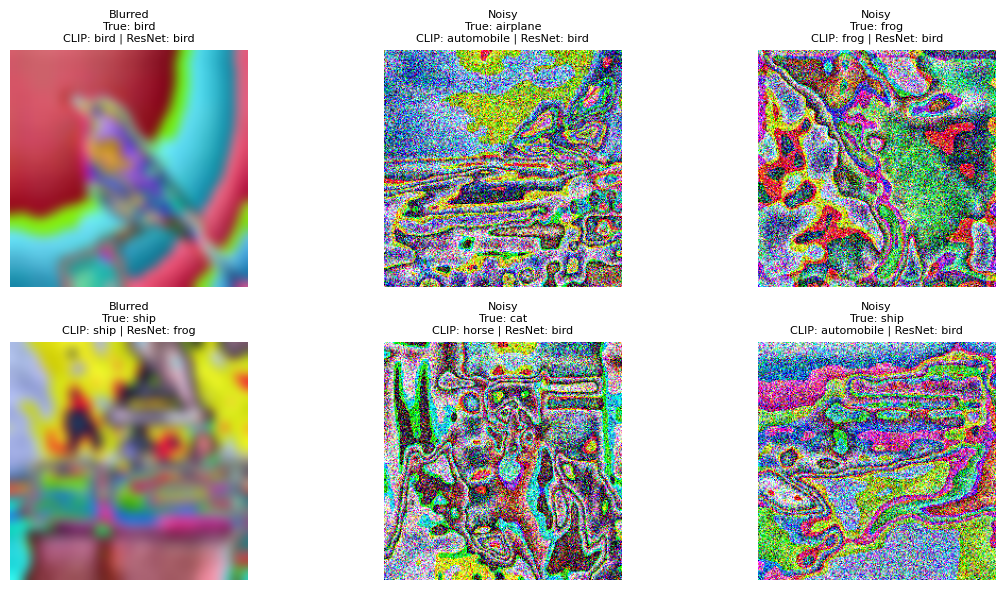

In [130]:
show_robust_samples(robust_df, n=6)


/tmp/ipython-input-3474268924.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fail_counts = robust_df.groupby(["Corruption","True Label"]).apply(


CLIP Fails  ResNet Fails
Corruption True Label                          
Blurred    airplane             0             1
           bird                 0             0
           cat                  1             1
           frog                 1             0
           horse                0             1
           ship                 1             3
Noisy      airplane             1             1
           bird                 0             0
           cat                  1             1
           frog                 0             1
           horse                0             1
           ship                 3             3

/tmp/ipython-input-3474268924.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_corr = robust_df.groupby("Corruption").apply(


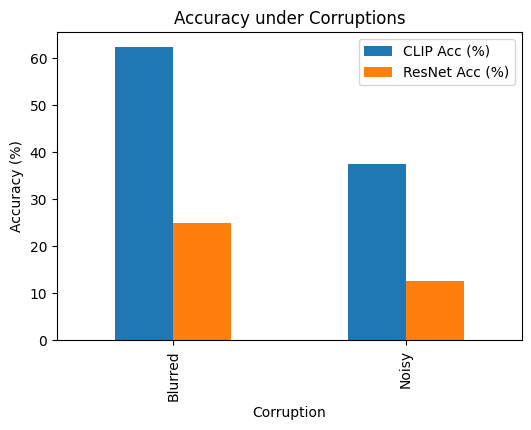

In [131]:
fail_counts = robust_df.groupby(["Corruption","True Label"]).apply(
    lambda df: pd.Series({
        "CLIP Fails": (df["CLIP Prediction"] != df["True Label"]).sum(),
        "ResNet Fails": (df["ResNet Prediction"] != df["True Label"]).sum()
    })
)
display(fail_counts.head(20))

acc_by_corr = robust_df.groupby("Corruption").apply(
    lambda df: pd.Series({
        "CLIP Acc (%)": (df["CLIP Prediction"]==df["True Label"]).mean()*100,
        "ResNet Acc (%)": (df["ResNet Prediction"]==df["True Label"]).mean()*100
    })
)
acc_by_corr.plot(kind="bar", figsize=(6,4), title="Accuracy under Corruptions")
plt.ylabel("Accuracy (%)"); plt.show()

In [132]:
print("\nExact corruption-wise accuracy (%):\n")
print(acc_by_corr.round(2))


Exact corruption-wise accuracy (%):

            CLIP Acc (%)  ResNet Acc (%)
Corruption                              
Blurred             62.5            25.0
Noisy               37.5            12.5
